# Portfolio Analysis

In [1]:
import polars as pl
import pandas as pd
import numpy as np
from pytz import timezone
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
import seaborn as sns
from pydantic import BaseModel
from typing import Optional,Union
from enum import Enum
from scipy.stats import weibull_min
sns.set_theme(style="whitegrid")

## Get Data

### Electriciy Prices

![EIA Hub Map](https://www.eia.gov/electricity/wholesale/images/hub-map.png)

In [2]:
def read_daily_electiricity_prices(year)->pd.DataFrame:
    if year>2016:
        extension = "xlsx"
    else:
        extension = "xls"
    df = pd.read_excel(f"https://www.eia.gov/electricity/wholesale/xls/archive/ice_electric-{year}final.{extension}", engine='calamine')
    # remove \n and \r from column names
    df.columns = [c.replace('\n','').replace('\r','') for c in df.columns]
    return df
daily_prices = pd.concat([read_daily_electiricity_prices(y) for y in range(2015,2025)])
daily_prices.head()

,Price hub,Trade date,Delivery start date,Delivery end date,High price $/MWh,Low price $/MWh,Wtd avg price $/MWh,Change,Daily volume MWh,Number of trades,Number of counterparties
0,ERCOT North 345KV Peak,2015-01-02 00:00:00,2015-01-05,2015-01-05,40.00,39.00,39.50,10.58,1600,2,3
1,ERCOT North 345KV Peak,2015-01-05 00:00:00,2015-01-06,2015-01-06,29.50,28.50,29.07,-10.43,12000,15,12
2,ERCOT North 345KV Peak,2015-01-07 00:00:00,2015-01-08,2015-01-08,43.00,41.50,42.25,13.18,6400,8,9
3,ERCOT North 345KV Peak,2015-01-08 00:00:00,2015-01-09,2015-01-09,31.00,29.50,29.86,-12.39,17600,20,11
4,ERCOT North 345KV Peak,2015-01-09 00:00:00,2015-01-12,2015-01-12,28.75,27.25,27.70,-2.16,4000,5,7


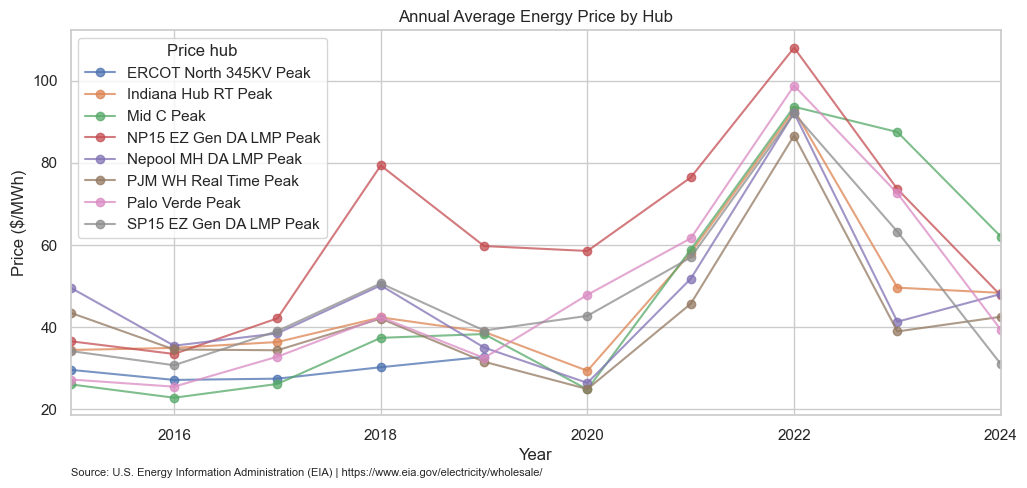

In [3]:
daily_mean_price = daily_prices.groupby(['Price hub','Delivery start date'])['Wtd avg price $/MWh'].mean().unstack(0)
fig,ax=plt.subplots(figsize=(12,5))
annual_mean_price =daily_mean_price.resample('YE').mean()
annual_mean_price.plot(ax=ax,title="Annual Average Energy Price by Hub",xlabel='Year',ylabel='Price ($/MWh)',style='-o',alpha=0.75)
# include a caption at the bottom with data source
ax.text(0,-0.15,"Source: U.S. Energy Information Administration (EIA) | https://www.eia.gov/electricity/wholesale/",transform=ax.transAxes,ha='left',va='center',fontsize=8);

In [4]:
# hourly prices are also publicly available from EIA.  This repo contains a preprocessed version for 2015-2023.
hourly_prices = pd.read_parquet(f"datasets/hub_lmp_prices.parquet")
iso_average_hourly_price = hourly_prices.pivot_table(index='GMT Datetime (Hour Ending)',columns='ISO Name',values='Price $/MWh',aggfunc='mean').loc['2015-01-01':'2023-12-31']
iso_average_hourly_price.head()

ISO Name,Alberta ISO,CENACE (ISO),California ISO,ERCOT ISO,IESO (Ontario),Midcontinent ISO,New England ISO,New York ISO,PJM ISO,SPP
GMT Datetime (Hour Ending),,,,,,,,,,
2015-01-01 00:00:00+00:00,20.69,NaN,27.75975,30.73415,11.72,23.54,75.28,8.63,37.0919,25.8633
2015-01-01 01:00:00+00:00,24.76,NaN,73.88650,29.28910,7.71,21.91,61.13,6.96,28.9477,25.4385
2015-01-01 02:00:00+00:00,21.95,NaN,107.73245,27.24835,0.40,21.12,55.91,6.88,28.1986,24.0461
2015-01-01 03:00:00+00:00,20.39,NaN,65.30870,25.97275,1.23,19.46,55.92,14.82,27.5806,23.5232
2015-01-01 04:00:00+00:00,20.29,NaN,54.12000,24.40925,0.00,20.52,50.65,11.61,28.2071,23.1283


In [5]:
mean_prices = iso_average_hourly_price.loc[:'2020',:].mean()
mean_prices.round(2)

ISO Name
Alberta ISO          37.62
CENACE (ISO)        979.28
California ISO       33.35
ERCOT ISO            25.11
IESO (Ontario)       17.12
Midcontinent ISO     21.88
New England ISO      33.57
New York ISO         21.85
PJM ISO              29.58
SPP                  24.38
dtype: float64

### US Counties and ISO Regions

In [6]:
county_metadata = pd.read_csv(f"datasets/County_ISO_Mapping.csv",dtype={'FIPS':str})
tz_mapping = {
    'Eastern':timezone('America/New_York'),
    'Central':timezone('America/Chicago'),
    'Mountain':timezone('America/Denver'),
    'Pacific':timezone('America/Los_Angeles')
}
county_metadata['timezone'] = county_metadata['County Time Zone Name'].map(tz_mapping)
county_metadata = county_metadata.dropna(subset=['iso_price_name']).set_index('FIPS')
county_metadata.head()

,state_name,state_abbrev,county,lat county,long county,county_id,lat (pop weighted) county,long (pop weighted) county,lat (pop weighted) state,long (pop weighted) state,County Time Zone Index,County Time Zone Name,iso_price_name,timezone
FIPS,,,,,,,,,,,,,,
53033,washington,wa,king,47.490196,-121.970665,17,47.585491,-122.313560,47.606209,-122.332071,0,Pacific,California ISO,America/Los_Angeles
30003,montana,mt,big_horn,45.428066,-107.473656,85,45.733139,-107.633217,45.783286,-108.500690,1,Mountain,SPP,America/Denver
30013,montana,mt,cascade,47.336441,-111.366035,90,47.500988,-111.343819,45.783286,-108.500690,1,Mountain,SPP,America/Denver
30017,montana,mt,custer,46.249863,-105.574417,92,46.394325,-105.869324,45.783286,-108.500690,1,Mountain,SPP,America/Denver
30021,montana,mt,dawson,47.264610,-104.895248,94,47.103050,-104.744766,45.783286,-108.500690,1,Mountain,Midcontinent ISO,America/Denver


### Energy Loss Model

<Axes: xlabel='annual energy loss pct', ylabel='Count'>

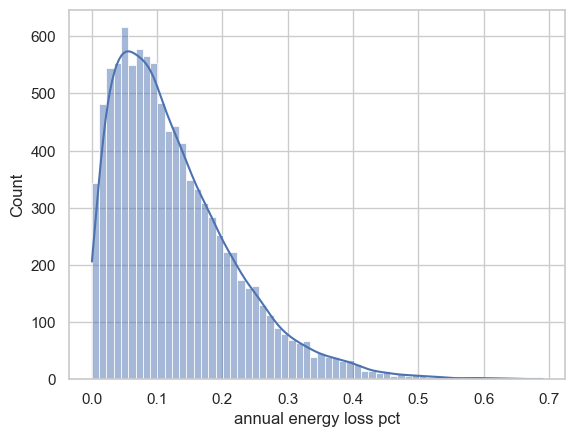

In [7]:
loss_pct_weibull_model = {
    'shape':1.343,
    'loc':0.0,
    'scale':0.138
}
samples = pd.Series(data=weibull_min.rvs(loss_pct_weibull_model['shape'],loss_pct_weibull_model['loc'],loss_pct_weibull_model['scale'],size=10000), name='annual energy loss pct')
mean_loss_pct = samples.mean()
sns.histplot(samples,kde=True)

### VCE RARE Dataset
the full dataset is a large parquet file and can be accessed directly from AWS S3.  For this analysis, we'll download it locally for quicker access.  For other access options, see the documentation https://catalystcoop-pudl.readthedocs.io/en/nightly/

https://s3.us-west-2.amazonaws.com/pudl.catalyst.coop/nightly/out_vcerare__hourly_available_capacity_factor.parquet

In [8]:
vce_rare_filename = "C:/Users/steve.lightfoote/Pattern Energy Group/Fundamentals & New Markets - Documents/General/4. Fundamentals/MET/RARE/out_vcerare__hourly_available_capacity_factor.parquet"

## Create Portfolio

In [9]:
class Technology(Enum):
    """Enum for technology types."""

    offshore_wind = "offshore_wind"
    onshore_wind = "onshore_wind"
    solar = "solar"


OEMS = ["OEM1", "OEM2", "OEM3"]
MODELS = {
    "OEM1": ["ModelA", "ModelB"],
    "OEM2": ["ModelC", "ModelD"],
    "OEM3": ["ModelE", "ModelF"],
}

TECH_MAPPING = {
    # Technology.offshore_wind: "capacity_factor_offshore_wind",
    Technology.onshore_wind: "capacity_factor_onshore_wind",
    Technology.solar: "capacity_factor_solar_pv",
}

iso_tz = {
    'Alberta ISO': timezone('America/Edmonton'),
    'CENACE (ISO)': timezone('America/Mexico_City'),
    'California ISO': timezone('America/Los_Angeles'),
    'PJM ISO': timezone('America/New_York'),
    'ERCOT ISO': timezone('America/Chicago'),
    'Midcontinent ISO': timezone('America/Chicago'),
    'New York ISO': timezone('America/New_York'),
    'New England ISO': timezone('America/New_York'),
    'IESO (Ontario)': timezone('America/Toronto'),
    'SPP': timezone('America/Chicago'),
}


class Asset(BaseModel):
    fips: str
    name: str
    technology: Technology
    capacity_mw: float
    gen: Optional[pd.Series] = None  # MWh
    fixed_energy_price: float  # $/MWh
    merchant_energy_price: pd.Series  # $/MWh
    merchant_pct: float = 0.0  # percentage of energy sold at market price
    county: Optional[str] = None
    latitude: Optional[float] = None
    longitude: Optional[float] = None
    timezone: Optional[timezone] = None
    oem: str = "generic"
    model: str = "generic"
    ownership_pct: float = 1.0
    cost: float = 0.0  # $/MWh

    class Config:
        arbitrary_types_allowed = True

    def revenue(self) -> pd.Series:
        """Calculate the revenue for the asset."""
        if self.gen is None:
            raise ValueError("Generation data is not set for the asset.")
        energy_price = (
            (self.fixed_energy_price * (1 - self.merchant_pct))
            + (self.merchant_energy_price * self.merchant_pct)
        )
        return self.gen * energy_price.reindex(self.gen.index) * self.ownership_pct

    def net_revenue(self) -> pd.Series:
        """Calculate the net revenue for the asset."""
        return self.revenue() - (self.cost * self.gen)

    def total_capacity(self) -> float:
        """Calculate the total capacity for the asset."""
        return self.capacity_mw * self.ownership_pct


class Portfolio(BaseModel):
    name: str
    assets: list[Asset]
    
    def gen(self) -> pd.DataFrame:
        return pd.DataFrame(
            {asset.name: asset.gen for asset in self.assets if asset.gen is not None}
        )

    def revenue(self) -> pd.DataFrame:
        return pd.DataFrame(
            {asset.name: asset.revenue() for asset in self.assets if asset.gen is not None}
        )
    def net_revenue(self) -> pd.DataFrame:
        return pd.DataFrame(
            {asset.name: asset.net_revenue() for asset in self.assets if asset.gen is not None}
        )

    def geodataframe(self) -> gpd.GeoDataFrame:
        tmp = pd.DataFrame(self.model_dump()["assets"])
        return gpd.GeoDataFrame(
            tmp,
            geometry=gpd.points_from_xy(tmp.longitude, tmp.latitude),
            crs="EPSG:4326",
        )

    def map(self, title: str = "Portfolio Map"):
        fig, ax = plt.subplots(figsize=(10, 6))
        sns.scatterplot(
            data=self.geodataframe(),
            x="longitude",
            y="latitude",
            hue="technology",
            style="technology",
            size="capacity_mw",
            ax=ax,
        )
        ax.set_xlim(-130, -65)
        ax.set_ylim(25, 50)
        cx.add_basemap(
            ax, zoom=5, source=cx.providers.CartoDB.Positron, crs="EPSG:4326"
        )
        # put legend outside the plot on the right
        ax.legend(bbox_to_anchor=(1.01, 1), loc="upper left", borderaxespad=0.0)
        ax.set_title(title)
        return fig, ax

C:\Users\steve.lightfoote\AppData\Local\Temp\ipykernel_16560\200503361.py:36: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class Asset(BaseModel):


In [10]:
def portfolio_gen(
    portfolio: Portfolio,
    path: str = vce_rare_filename,
) -> pd.DataFrame:
    """Get the generation for the portfolio."""
    tmp = (
        pl.scan_parquet(path)
        .select(["datetime_utc", "county_id_fips"] + list(TECH_MAPPING.values()))
        .filter(pl.col("county_id_fips").is_in([a.fips for a in portfolio.assets]))
        .collect()
        .to_pandas()
        .set_index("datetime_utc")
        .tz_localize("UTC")
    )
    gen = pd.concat(
        {
            a.name: (
                tmp.loc[tmp["county_id_fips"] == a.fips, TECH_MAPPING[a.technology]]
                * a.capacity_mw
            )
            for a in portfolio.assets
        },
        axis=1,
    )
    return gen


def create_random_portfolio(
    name: str,
    n_assets: int,
    mean_ppa_prices: pd.Series = mean_prices,
    county_metadata: pd.DataFrame = county_metadata,
    iso_average_hourly_price: pd.DataFrame = iso_average_hourly_price,
    merchant_pct: float = 0.0,
) -> Portfolio:
    assets = []
    for i in range(n_assets):
        fips = np.random.choice(county_metadata.index, 1).tolist()[0]
        technology = np.random.choice(list(TECH_MAPPING.keys()), 1).tolist()[0]
        capacity_mw = np.random.uniform(20, 1000)
        oem = np.random.choice(OEMS, 1).tolist()[0]
        model = np.random.choice(MODELS[oem], 1).tolist()[0]
        # get the iso price for the county
        iso_name = county_metadata.loc[fips, "iso_price_name"]
        fixed_energy_price = mean_ppa_prices[iso_name]
        merchant_price = iso_average_hourly_price[iso_name].copy()
        asset = Asset(
            fips=fips,
            name=f"{technology.value}_{i}",
            technology=technology,
            capacity_mw=capacity_mw,
            oem=oem,
            model=model,
            latitude=county_metadata.loc[fips, "lat county"],
            longitude=county_metadata.loc[fips, "long county"],
            county = county_metadata.loc[fips, "county"],
            fixed_energy_price=fixed_energy_price,
            merchant_energy_price=merchant_price,
            merchant_pct=merchant_pct,
            # timezone=county_metadata.loc[fips, "timezone"]
        )
        assets.append(asset)
    portfolio = Portfolio(name=name, assets=assets)

    # get and assign generation to each asset
    gen = portfolio_gen(portfolio)
    for a in portfolio.assets:
        a.gen = gen[a.name]
    return portfolio

In [11]:
# set numpy random seed for reproducibility.  remove this if you want different results each time
# np.random.seed(42)
portfolio = create_random_portfolio("Portfolio A", n_assets=30,merchant_pct=0)
portfolio.geodataframe().drop(columns=['gen','merchant_energy_price'])

,fips,name,technology,capacity_mw,fixed_energy_price,merchant_pct,county,latitude,longitude,timezone,oem,model,ownership_pct,cost,geometry
0,17199,onshore_wind_0,Technology.onshore_wind,137.761789,21.875295,0.0,williamson,37.730877,-88.931953,None,OEM2,ModelD,1.0,0.0,POINT (-88.93195 37.73088)
1,36003,solar_1,Technology.solar,431.925529,21.854681,0.0,allegany,42.256130,-78.030640,None,OEM2,ModelC,1.0,0.0,POINT (-78.03064 42.25613)
2,42059,onshore_wind_2,Technology.onshore_wind,313.843666,29.583039,0.0,greene,39.854847,-80.225975,None,OEM1,ModelA,1.0,0.0,POINT (-80.22598 39.85485)
3,33019,onshore_wind_3,Technology.onshore_wind,841.456809,33.573291,0.0,sullivan,43.362541,-72.216919,None,OEM2,ModelC,1.0,0.0,POINT (-72.21692 43.36254)
4,48035,onshore_wind_4,Technology.onshore_wind,70.703802,25.111356,0.0,bosque,31.901649,-97.633209,None,OEM2,ModelC,1.0,0.0,POINT (-97.63321 31.90165)
5,19075,solar_5,Technology.solar,805.497191,21.875295,0.0,grundy,42.404301,-92.798813,None,OEM2,ModelD,1.0,0.0,POINT (-92.79881 42.4043)
6,18051,solar_6,Technology.solar,853.109949,21.875295,0.0,gibson,38.312767,-87.581268,None,OEM2,ModelD,1.0,0.0,POINT (-87.58127 38.31277)
7,36093,solar_7,Technology.solar,889.982555,21.854681,0.0,schenectady,42.817249,-74.060547,None,OEM1,ModelA,1.0,0.0,POINT (-74.06055 42.81725)
8,19137,onshore_wind_8,Technology.onshore_wind,81.772700,21.875295,0.0,montgomery,41.033367,-95.163818,None,OEM1,ModelB,1.0,0.0,POINT (-95.16382 41.03337)
9,48503,onshore_wind_9,Technology.onshore_wind,405.952832,25.111356,0.0,young,33.175983,-98.692413,None,OEM1,ModelB,1.0,0.0,POINT (-98.69241 33.17598)


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Portfolio A'}, xlabel='longitude', ylabel='latitude'>)

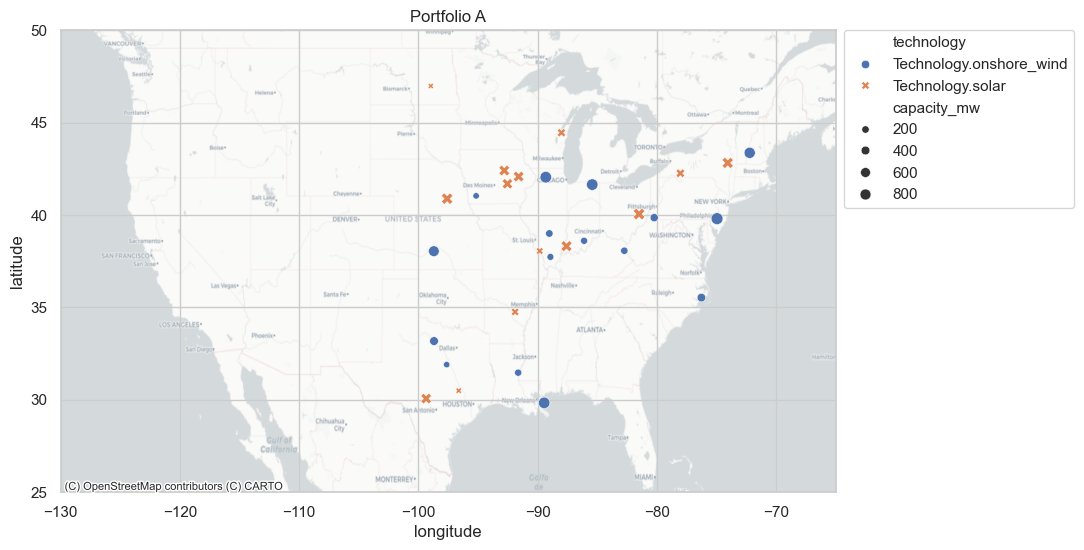

In [12]:
portfolio.map(title=portfolio.name)

## Simulate Portfolio Revenue

In [13]:
def annual_sim(portfolio,merchant_pct:float=0.0):
    hourly_sim = pd.concat({'gen':portfolio.gen(),'revenue':portfolio.revenue()},axis=1)
    annual = hourly_sim.resample('YE').sum().iloc[1:,:].copy()
    s = annual.xs('gen',axis=1).shape
    n_samples = s[0] * s[1]
    losses = weibull_min.rvs(loss_pct_weibull_model['shape'],loss_pct_weibull_model['loc'],loss_pct_weibull_model['scale'], size=n_samples).reshape(s)
    idx=pd.IndexSlice
    net_gen = annual.xs('gen',axis=1) * (1-(losses-mean_loss_pct))
    # add in a 1% degradation factor per year to net_gen
    degradation = ((1 - 0.01 * np.arange(1, net_gen.shape[0] + 1)).reshape(-1, 1)+0.05)
    net_gen_with_degradation = net_gen * degradation
    net_revenue = net_gen_with_degradation * (annual.xs('revenue',axis=1)/annual.xs('gen',axis=1))
    annual = pd.concat({'gen':annual.xs('gen',axis=1),'net_gen':net_gen,'net_gen_with_degradation':net_gen_with_degradation,'net_revenue':net_revenue},axis=1)
    return annual

In [14]:
# run annual sim with merchant_pct = np.arange(0,1.1,0.1)
merchant_pcts = [0,0.1,0.2,0.5,1.0]
sims = {}
for mp in merchant_pcts:
    print(mp)
    for a in portfolio.assets:
        a.merchant_pct = mp
    sims[mp] = annual_sim(portfolio,merchant_pct=mp)

0
0.1
0.2
0.5
1.0


In [15]:
k = 0.0
portfolio_annual = sims[k].stack(0).sum(axis=1).unstack(1).rename(columns = {'net_revenue':'Revenue 0% merchant'}).copy()
for mp in merchant_pcts[1:]:
    col_name = f'Revenue {int(mp*100)}% merchant'
    tmp = sims[mp].stack(0).sum(axis=1).unstack(1).rename(columns = {'net_revenue':col_name})
    portfolio_annual[col_name] = tmp[col_name]
portfolio_anomaly = portfolio_annual.iloc[:,0:3].div(portfolio_annual.iloc[:,0:3].mean()) - 1
for mp in merchant_pcts:
    portfolio_anomaly[f'Revenue {int(mp*100)}% merchant'] = portfolio_annual[f'Revenue {int(mp*100)}% merchant'].div(portfolio_annual[f'Revenue 0% merchant'].mean()) - 1

C:\Users\steve.lightfoote\AppData\Local\Temp\ipykernel_16560\1134341565.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  portfolio_annual = sims[k].stack(0).sum(axis=1).unstack(1).rename(columns = {'net_revenue':'Revenue 0% merchant'}).copy()
C:\Users\steve.lightfoote\AppData\Local\Temp\ipykernel_16560\1134341565.py:5: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  tmp = sims[mp].stack(0).sum(axis=1).unstack(1).rename(columns = {'net_revenue':col_name})
C:\Users\steve.lightfoote\AppData\Local\Temp\ipykernel_16560\1134341565.py:5: FutureWarning: The previous implementa

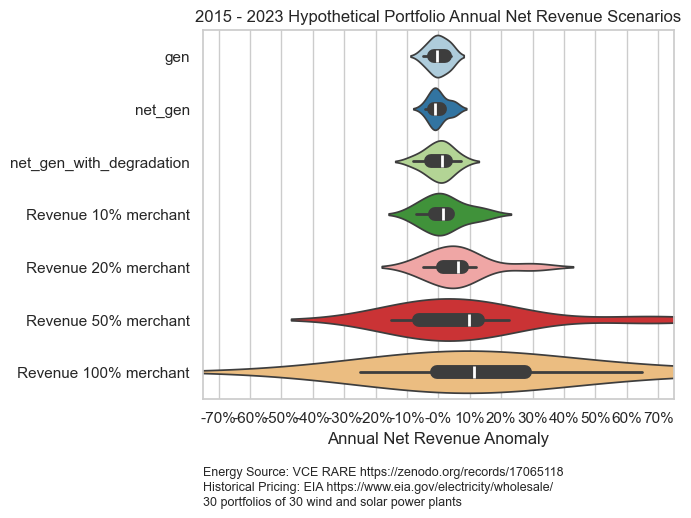

In [16]:
fig,ax = plt.subplots(figsize=(7,5.5))
sns.violinplot(portfolio_anomaly.drop(columns = 'Revenue 0% merchant'),ax=ax,orient='h',fill=True,palette='Paired',inner_kws=dict(box_width=10, whis_width=2))
# make x axis labels as percentages
ax.set_xlim(-.75,0.75)
ax.set_xticks(np.arange(-.7,.71,0.1))
ax.set_xticklabels([f"{x:.0%}" for x in ax.get_xticks()])
ax.set_title("2015 - 2023 Hypothetical Portfolio Annual Net Revenue Scenarios")
ax.set_xlabel("Annual Net Revenue Anomaly")
# write a caption at the bottom with data source
ax.text(0,-0.2,"Energy Source: VCE RARE https://zenodo.org/records/17065118",transform=ax.transAxes,ha='left',va='center',fontsize=9);
ax.text(0,-0.24,"Historical Pricing: EIA https://www.eia.gov/electricity/wholesale/",transform=ax.transAxes,ha='left',va='center',fontsize=9);
ax.text(0,-0.28,"30 portfolios of 30 wind and solar power plants",transform=ax.transAxes,ha='left',va='center',fontsize=9);
plt.tight_layout()